In [1]:
%matplotlib inline

In [3]:
import os
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

fetch_housing_data()
housing = load_housing_data()


In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housing, housing["income_cat"]):
    train_set = housing.loc[train_idx]
    test_set = housing.loc[test_idx]


for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True)

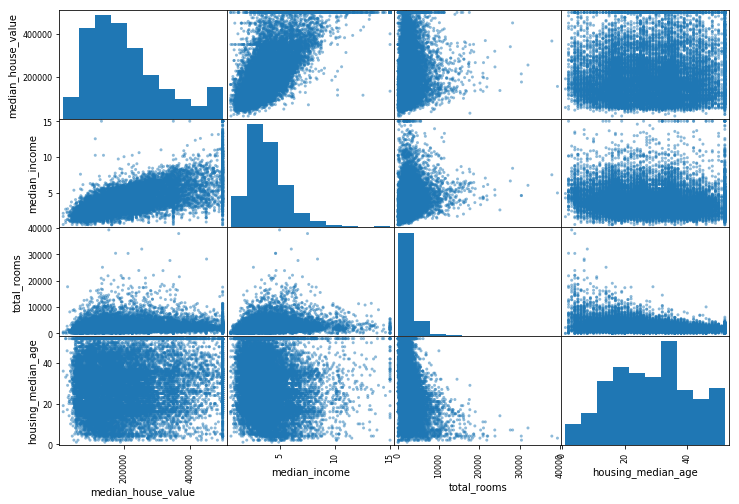

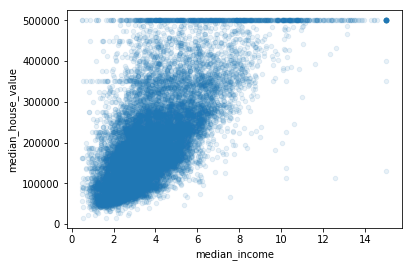

In [5]:
from pandas.plotting import scatter_matrix

housing = train_set.copy()

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

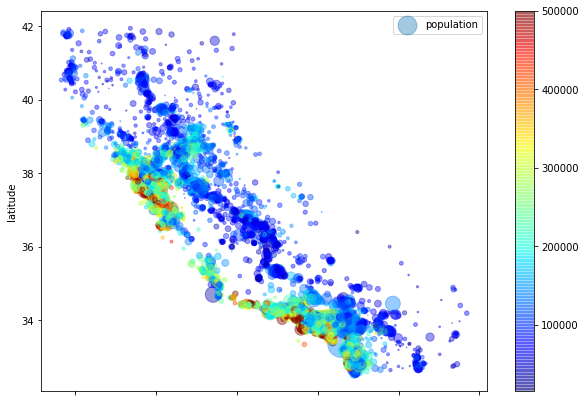

In [6]:
import matplotlib.pyplot as plt

housing.plot(kind="scatter", x="longitude",	y="latitude", alpha=0.4, figsize=(10, 7),
             c=housing["median_house_value"], s=housing["population"]/50, cmap=plt.get_cmap("jet"), label="population")
plt.legend()

In [14]:
from sklearn.preprocessing import Imputer, LabelBinarizer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

housing = train_set.drop("median_house_value", axis=1)
housing_labels = train_set["median_house_value"].copy()
housing_num = housing.drop("ocean_proximity", axis=1)

imputer = Imputer(strategy="median")
X = imputer.fit_transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr

encoder = LabelBinarizer(sparse_output=True)
encoder.fit_transform(housing["ocean_proximity"])

housing.columns.values

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6


class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
        
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attribute_names].values


num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributeAdder()),
        ('std_scaler', StandardScaler())
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer())
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline)
    ])


housing_prepared = full_pipeline.fit_transform(housing)

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
print(tree_rmse_scores)
print(tree_rmse_scores.mean())


[66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
69052.46136345083


In [88]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64